# Talking to Ourselves - Simulated Conversation with Natural Language Processing

## Abstract

## Chatbots
Chatbots hold a special place in the history and philosphy of artificial intelligence because of the Turing test. Originally proposed by Alan Turing in 1950 as the *Imitation Game*, the Turing test considers the question, 'Can Machines think?' by asking the question, 'Can a human distinguish between a machine and another human?' (cite). While many researchers have explored and critcized Turing's idea, creating chatbots that are able to simulate human-like responses remains a tenant of artificial intelligence research.

Today, chatbots can most often be found as tools to aid in customer support or psychotherapy, or as agents of fun or entertainment. To be effective, a chatbot must be able to do the following things:
- Parse user input
- intepret the meaning of the user input
- provide an appropriate response

Chatbots can be categorized in many different ways like which response architecture is used to generate responses, conversational domains, or by who is able to initiative conversation. Response architecture can be rule-based, retrieval-based, or generative. In rule-based models, the system generated responses are entirely predefined and are returned according to a series of rules, typically using a decision tree and clearly defined possible outputs for each step in the conversation. In retrieval-based models, machine learning models are typically used to intepret user queries and responses are pulled from an existing corpus of dialogs. Like rule-based models, retreival-based models typically rely on predefined responses, but can improve their selection of responses over time. Generative models form original responses based on user input. This project will use a generative model to simulate more human-like responses.

## Something about our data, transformers, model... something?

## Initial setup

# Packages
We will be using the following packages:
- re                 : for regular expression matching operations.
- time               : for something... (**remember to explain this**)
- NumPy              : for use with array objects
- TensorFlow         : for building our transformer
- TensorFlow_datasets: for preparing and processing our dataset

re and time are part of the Python Standard Library and usually come pre-installed with Python. NumPy can be installed using either conda or pip. Installing TensorFlow, and TensorFlow Datasets can be a lengthy and challenging process so I recommend following the instructions on the TensorFlow website. 

For this project, we are using the Paperspace Gradient platform because of its quick setup, ease of use, and low operating costs. Paperspace has several template runtimes that come with NumPy and TensorFlow pre-installed.

In [1]:
!pip install tensorflow_datasets -Uqq

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys

import os
import re
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tf.keras.utils.set_random_seed(1234)

print(f"Tensorflow version {tf.__version__}")

Tensorflow version 2.9.1


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU {}".format(tpu.cluster_spec().as_dict()["worker"]))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print(f"REPLICAS: {strategy.num_replicas_in_sync}")

REPLICAS: 1


# Hyperparameters

Hyperparameter tuning is beyond the scope of this project. As such, we will be using the following arbitrarily determined settings to attempt to balance time and performance.

In [4]:
#Maximum sentence length
MAX_LENGTH = 40

#Maximum number of samples to preprocess
MAX_SAMPLES = 50000

#For tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

#For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 40

## Dataset

Generating dialog is typically achieved by feeding machine translation models a dataset that is separated by speakers and typically described as a question and an answer. For this project, we will be using the Cornell Movie-Dialogs Corpus as our dataset, which contains 220,579 conversational exchanges between 10,292 pairs of movie characters (cite). This dataset is sufficiently large, rich, and processed. This will allow us to focus on the intent of this project - learning how to build a language model using transformers.

The dataset is broken into two documents:
- movie_conversations.txt: Contains a list of conversation IDs, each containing a list of line IDs for that conversation.
- movie_lines.text       : Contains the text associated with each conversation ID.

In [5]:
#Download the dataset
path_to_zip = tf.keras.utils.get_file(
    "cornell_movie_dialogs.zip",
    origin="http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip",
    extract=True,
)
#Set the path to the dataset
path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus"
)
#Set the path to the list of conversations
path_to_movie_conversations = os.path.join(path_to_dataset, "movie_conversations.txt")

#Set the path to the text associated with each conversation
path_to_movie_lines = os.path.join(path_to_dataset, "movie_lines.txt")

# Preparing the Dataset

To train our model, our data needs to be structured in a way that our model can use it. To do that, we will be doing the following:
1. Build a dictionary from the movie_lines.txt file with the movie lines as the keys and the text of the lines as the values
2. Preprocessing each sentence by converting to lowercase and removing white space, contractions, and special characters.
3. Iterate through each conversation in the movie_conversations.txt file.
4. Iterate through each line in a conversations, adding that line to the list of questions (input sentences) and the following line to the list of answers (output sentences).
5. Build a tokenizer using TensorFlow Datasets SubwordTextEncoder.
6. Tokenize each sentence.
7. Add START_TOKENS and END_TOKENS to indicate the start and end of each sentence.
8. Filter out sentences that have more than 60 tokens. 
9. Pad tokenized sentences that have less than 60 tokens.

In [6]:
def preprocess_sentence(sentence):
    #convert to all lower case and remove white space at the beginning and end
    sentence = sentence.lower().strip()
    #creating a space between a word and the punctuation following it
    # ex. "He is a boy." -> "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    #removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    #replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    #remove white space at the beginning and end
    sentence = sentence.strip() 
    return sentence

def load_conversations():
    #dictionary of line id to text
    id2line = {}
    with open(path_to_movie_lines, errors="ignore") as file:
        lines = file.readlines()
    for line in lines:
        #Remove the new line "\n"
        #" +++$+++ " is being used as a field separator in all of the files
        #Use this to separate text into lists, Should look something like this:
        # Conversation Line ID, Character (Speaker) ID, Movie ID, Character Name, Text#        
        parts = line.replace("\n", "").split(" +++$+++ ")
        #Set the Conversation line ID as a key and the text as the value
        id2line[parts[0]] = parts[4]
        
    inputs, outputs = [], []
    with open(path_to_movie_conversations, "r") as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        #Set each conversation as a list of line IDs (parts[3])
        conversation = [line[1:-1] for line in parts[3][1:-1].split(", ")]
        #For each conversation, set input as line 1, output as line 2, input as line 2, output as line 3... etc.
        #Process each sentence by removing special characters, etc. (see preprocess_sentence above)
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    return inputs, outputs

#Define conversational starters or inputs as questions (or prompts)
#Define conversational reactions or outputs as answers (or replies)
questions, answers = load_conversations()
    

In [7]:
#Build tokenizer using tfds for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size = 2**13)

#Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

#Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size +2

In [8]:
#Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        #tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        #check tokenized sentence max length
        #Filter sentence length > 40
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            
            
    #pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding="post"
    )
    
    return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)
    

In [9]:
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

Vocab size: 8279
Number of samples: 44131


Create tf.data.Dataset

In [10]:
#decoder inputs use the previous target as input
#remove START_TOKEN from targets
#Uses the tensorflow API to construct a Dataset object from memory
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "dec_inputs": answers[:,:-1]},
        {"outputs": answers[:, 1:]},
    )
)
#Cache the dataset, saving time operations (like file opening and data reading from being executed during each epoch
dataset = dataset.cache()
#.shuffle maintains an internal buffer of elements, reducing memory footprint
dataset = dataset.shuffle(BUFFER_SIZE)
#set the batch size
dataset = dataset.batch(BATCH_SIZE)
#Prefetching overlaps the preprocessing and model execution of a training step
#While the model is executing training step s, the input pipeline is reading the data for step s+1, reducing step time
#tf.data.AUTOTUNE prompts the tf.data runtime to dynamically adjust the number of elements to prefetch at runtime
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [11]:
print(dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


Attention
Scaled dot product attention

In [12]:
#Module that computes the attention weights for the input and
#produces an output vector with encoded information on how each word should
#attend to all other words in the sequence
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights."""
    #Matrix mutliply query by transposed key to generate to produce a score matrix
    #Score matrix determines how much focus should a word be put on other words
    #Each word will have a score that corresponds to other words in a timestep
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    #scale matmul_qk
    #Scales the scores down to allow for more stable gradients
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    

    #add the mask to zero out padding tokens
    if mask is not None:
        logits += mask * -1e9
        
    #softmax gives probability values between 0 and 1 for attention weights
    #softmax heightens higher scores and depresses lower scores
    #This allows the model to be more confident on which words to attend to
    #softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    output = tf.matmul(attention_weights, value)
    
    return output

Multi-Headed Attention
Instead of one single attention head, query, key, and value are split inito multiple heads.
This allows the model to jointly attend to information at different positions from different representational spaces.
After the split, each head has a reduced dimensionality, leading to a total computation cost that is the same as a single head attention with full dimensionality

In [13]:
#Setup a multi-head attention layer
#layers are functions with a known mathematical structure that can be reused
#and have trainable variables
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        #check to see if the data model is divisible by the number of heads
        assert d_model % num_heads == 0
        #Inherit the methods of tf.keras.layers.Layer
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        #setup linear dense layers for the query, key, and value inputs
        #Each "neuron" in the dense layer receives input from all neurons of its previous layer
        #Dense layer performs a matrix-vector multiplication, values are paremeters that can be trained
        #and updated with the help of backpropogation
        #units represents the output size of the layer (in this case, the size of the data model)
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def get_config(self):
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config
    #Split query, key, and value into multiple heads
    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3]) #perm sets the dimension of the returned matrix
        )(inputs)
    
    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]
        
        #Linear Layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
    
        #split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
    
        #scaled dot-product attention
        #applied to each head (broadcast for efficiency)
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0,2,1,3])
        )(scaled_attention)
    
        #concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)
    
        #final linear layer
        outputs = self.dense(concat_attention)
    
        return outputs

Transformer
Masking

In [14]:
#Mask all the pad tokens (value 0) in the batch to ensure the model does not treat padding as input
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [15]:
print(create_padding_mask(tf.constant([[1,2,0,3,0], [0,0,0,4,5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [16]:
#Decoder layer is autoregressive and generates sequence word by word
#Prevent the decoder from conditioning to future tokens
#Add a look-ahead mask, zeroing out future tokens
#ex. to predict a 4th word, only the first, second, and 3rd word will be used
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [17]:
print(create_look_ahead_mask(tf.constant([[1,2,0,4,5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


Positional Encoding
Gives the model information about the relative position of the words in the sentence
Words will be closer to each other based on the similarity of their meaning and their position in the sentence

In [18]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config
    
    def get_angles(self, position, i, d_model):
        angles = 1/ tf.pow(10000, (2 * (i //2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position = tf.range(position, dtype = tf.float32)[:, tf.newaxis],
            i = tf.range(d_model, dtype = tf.float32)[tf.newaxis, :],
            d_model = d_model,
        )
        #apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        #apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        pos_encoding = tf.concat([sines, cosines], axis = -1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

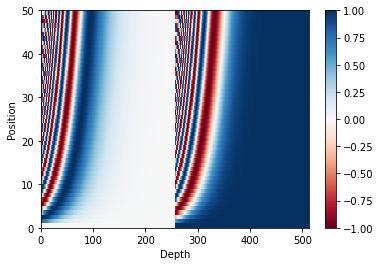

In [19]:
sample_pos_encoding = PositionalEncoding(50, 512, name="sample_pos_encoding")

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

Encoder Layer

In [20]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name = "inputs")
    padding_mask = tf.keras.Input(shape=(1,1,None), name = "padding_mask")
    
    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)
    
    outputs = tf.keras.layers.Dense(units=units, activation = "relu")(attention)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs = outputs, name=name)

Encoder

In [21]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1,1,None), name = "padding_mask")
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])
        
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs = outputs, name=name)
    

Decoder Layer

In [22]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name = "inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name = "encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name = "look_ahead_mask")
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = "padding_mask")
    
    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)
    
    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs = {
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)
    
    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

Decoder

In [23]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

Transformer

In [24]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

Train model
Loss function

In [25]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

Custom learning rate

In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(
            tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
        )

Initialize and compile model

In [27]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


# initialize and compile model within strategy scope
with strategy.scope():
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3172608     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

Fit model

model.fit(dataset, epochs=EPOCHS)

Save and load model

filename = "model.h5"
tf.keras.models.save_model(model, filepath=filename, include_optimizer=False)

del model
tf.keras.backend.clear_session()

In [28]:
filename = "model.h5"

model = tf.keras.models.load_model(
    filename,
    custom_objects={
        "PositionalEncoding": PositionalEncoding,
        "MultiHeadAttentionLayer": MultiHeadAttentionLayer,
    },
    compile=False,
)

Evaluate and Predict

In [29]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )
    return predicted_sentence

In [30]:
predict("Where have you been?")

'i am going to say that .'

In [31]:
predict("It's a trap")

'that is right . it ai not no shit .'

In [32]:
# feed the model with its previous output
sentence = "I am not crazy, my mother had me tested."
for _ in range(5):
    print(f"Input: {sentence}")
    sentence = predict(sentence)
    print(f"Output: {sentence}\n")

Input: I am not crazy, my mother had me tested.
Output: i do not want to talk about it . i want to see you again .

Input: i do not want to talk about it . i want to see you again .
Output: no , i will do something .

Input: no , i will do something .
Output: you are really a beautiful girl .

Input: you are really a beautiful girl .
Output: you were wrong , you quack , so i could not tell you .

Input: you were wrong , you quack , so i could not tell you .
Output: i know what i am talking about .



In [33]:
predict("Hi! How are you?")

'i am going to see you here , joel .'

In [36]:
class ChatBot:
    exit_commands = ("goodbye", "quit")
    
    def start_chat(self):
        user_response = input("Hi, I'm a chatbot trained on dialog from movies. Would you like to chat with me? \n")
        
        #If the user input contains goodbye or quit, exit the chatbot
        if user_response in self.exit_commands:
            print("Ok, have a great day!")
            return
        
        self.chat(user_response)
        
    def chat(self, reply):
        while not self.make_exit(reply):
            reply = input(self.generate_response(reply))
            
        
    def inference(self, sentence):
        sentence = preprocess_sentence(sentence)
        
        sentence = tf.expand_dims(
            START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
        )
        
        output = tf.expand_dims(START_TOKEN, 0)
        
        for i in range(MAX_LENGTH):
            predictions = model(inputs=[sentence, output], training=False)
            
            #select the last word from the seq_len dimension
            predictions = predictions[:, -1:, :]
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
            
            #return the result if the predicted_id is equal to the end token
            if tf.equal(predicted_id, END_TOKEN[0]):
                break
                
            #concatenated the predicted_id to the output which is given to the decoder as its input
            output = tf.concat([output, predicted_id], axis=-1)
            
        return tf.squeeze(output, axis=0)
    
    def generate_response(self, user_input):
        prediction = self.inference(user_input)
        response = tokenizer.decode(
            [i for i in prediction if i < tokenizer.vocab_size]
        )
        return "Chatty McChatbot: " + response + "\n User Input:"     
            
    def make_exit(self, reply):
        #If the user input contains goodbye or quit, exit the chatbot
        for exit_command in self.exit_commands:
            if exit_command in reply:
                print("Okay, have a great day!")
                return True
            
        return False

In [35]:
chatty_mcchatface = ChatBot()
chatty_mcchatface.start_chat()

Hi, I'm a chatbot trained on dialog from movies. Would you like to chat with me? 
 That sounds like fun
i will be right back .
 User Input: What?
i do not know . i am just guessing .
 User Input: You just said you wanted to chat
i think you are cute .
 User Input: exit
that is wrong ?
 User Input: quit


Okay, have a great day!
